In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
import seaborn as sns

**Data pre-processing**

In [3]:
#Code for creating data frame of testing data
data = pd.read_csv('requests.csv')
data.columns = ['timestamp', 'userID', 'sessionID', 'expiring', 'URL']

In [4]:
#Formatting the data frame so that each row represent one user. 
#All requests are saved as a string in the "URL"-column
users = list(data['userID'])
allUsers = data.set_index(['userID']).rename_axis(None)
allUsers = allUsers.drop(columns=['timestamp', 'sessionID', 'expiring'])
df = allUsers.groupby(level=0).agg(','.join)
df.reset_index(inplace=True)
df = df.rename(columns={'index': 'users'})



In [5]:
#Removing all non-letter characters from the data and assigning it to new data frame 'df_cleaned'
df_cleaned = df
request_logs = df_cleaned['URL']

cleaned_logs = []

for i in range(0, len(request_logs)):
    sequence = re.sub('[^a-zA-Z]', ' ', request_logs[i])
    sequence = sequence.lower()
    cleaned_logs.append(sequence)

df_cleaned ['request_logs'] = cleaned_logs
df_cleaned = df_cleaned.drop('URL', axis=1)

# 5 and 6: spammers, 7: data scraper
#print(cleaned_logs[7])


In [37]:
df

,users,URL,request_logs
0,user-10,"/login, /searchUsers?page=0, /profile/372, /c...",login searchusers page profile c...
1,user-100,"/login, /searchUsers?page=0, /profile/716, /p...",login searchusers page profile p...
2,user-1000,"/login, /searchUsers?page=0, /profile/626, /c...",login searchusers page profile c...
3,user-1001,"/login, /searchUsers?page=0, /profile/117, /p...",login searchusers page profile p...
4,user-1002,"/login, /searchUsers?page=0, /profile/162, /c...",login searchusers page profile c...
...,...,...,...
999,user-995,"/login, /searchUsers?page=0, /profile/337, /p...",login searchusers page profile p...
1000,user-996,"/login, /searchUsers?page=0, /profile/642, /p...",login searchusers page profile p...
1001,user-997,"/login, /searchUsers?page=0, /profile/760, /c...",login searchusers page profile c...
1002,user-998,"/login, /searchUsers?page=0, /profile/944, /p...",login searchusers page profile p...


In [29]:
#Using the tfidf-vectorizer
tfidf_vect = TfidfVectorizer()
vect_logs = tfidf_vect.fit_transform(df_cleaned['request_logs'])

In [7]:

"""
Code for calculating variance, might delete
arr_values = []
#arr_variance = []

for i in range(0,1):
    for j in range (0, vect_logs.shape[1]):
        #print(vect_logs[i,j])
        val = vect_logs[i,j]
        arr_values.append(val)
        
print(arr_values, '\n')

array = np.array(arr_values)
print(array, '\n')
print(np.var([arr_values]))
"""

"\nCode for calculating variance, might delete\narr_values = []\n#arr_variance = []\n\nfor i in range(0,1):\n    for j in range (0, vect_logs.shape[1]):\n        #print(vect_logs[i,j])\n        val = vect_logs[i,j]\n        arr_values.append(val)\n        \nprint(arr_values, '\n')\n\narray = np.array(arr_values)\nprint(array, '\n')\nprint(np.var([arr_values]))\n"

In [34]:

#Code for checking an instance's request_logs

vector_instance=vect_logs[903] 
df_vectorized = pd.DataFrame(vector_instance.T.todense(), index=tfidf_vect.get_feature_names_out(), columns=["tfidf"])
df_vectorized.sort_values(by=["tfidf"], ascending=False)


,tfidf
profile,0.476063
page,0.475117
conversation,0.423589
searchusers,0.369535
login,0.316745
markasread,0.211794
config,0.133978
userconfig,0.133978
like,0.126036
photos,0.126036



Some annotations for later
variance normal user[0]: 0.030732589
variance normal user[1]: 0.040072223
variance spammer 1: 0.075907392
variance spammer 2: 0.075314139
variance data scraper: 0.25440979



In [58]:
df_tfidf_scores = pd.DataFrame(vect_logs.todense(), columns= tfidf_vect.get_feature_names_out())
users = df['users']
#df_complete = pd.concat([df, df_tfidf_scores], axis=1)
#df_complete = df_complete.drop('request_logs', axis=1)
#df_complete

#Tror att vi vill hålla dem separat så att vi bara har numeriska värden att köra in i modellen. Men nu finns det en korrekt indexerad lista på alla användare:)
#print(users)
print(df_tfidf_scores)

         block      chat    config  conversation     inbox      like  \
0     0.041854  0.282709  0.023893      0.566545  0.081970  0.000000   
1     0.000000  0.257209  0.000000      0.674041  0.043025  0.023595   
2     0.077396  0.261389  0.044181      0.593661  0.170523  0.041562   
3     0.000000  0.293644  0.046531      0.551679  0.019955  0.021886   
4     0.022696  0.183961  0.000000      0.655386  0.022224  0.024376   
...        ...       ...       ...           ...       ...       ...   
999   0.022091  0.268593  0.075665      0.518321  0.032449  0.071180   
1000  0.046054  0.308113  0.030046      0.593706  0.051540  0.028264   
1001  0.023284  0.167762  0.026584      0.672384  0.068402  0.050016   
1002  0.000000  0.256528  0.000000      0.599758  0.185947  0.050987   
1003  0.098973  0.356545  0.000000      0.625197  0.096917  0.053149   

         login  markasread      page    photos   profile    report  \
0     0.131800    0.283273  0.338914  0.000000  0.471651  0.07175

In [59]:
#Code to join the df_cleaned with the tf-idf scores. Try this with Isolation forest if we need to
joined_df = pd.concat([df_cleaned, df_tfidf_scores], axis = 1)
joined_df

,users,request_logs,block,chat,config,conversation,inbox,like,login,markasread,page,photos,profile,report,searchusers,send,userconfig
0,user-10,login searchusers page profile c...,0.041854,0.282709,0.023893,0.566545,0.081970,0.000000,0.131800,0.283273,0.338914,0.000000,0.471651,0.071751,0.263600,0.282709,0.023893
1,user-100,login searchusers page profile p...,0.000000,0.257209,0.000000,0.674041,0.043025,0.023595,0.098828,0.337020,0.217422,0.023595,0.455515,0.025107,0.177891,0.257209,0.000000
2,user-1000,login searchusers page profile c...,0.077396,0.261389,0.044181,0.593661,0.170523,0.041562,0.121860,0.296830,0.348171,0.041562,0.453524,0.044227,0.191494,0.261389,0.044181
3,user-1001,login searchusers page profile p...,0.000000,0.293644,0.046531,0.551679,0.019955,0.021886,0.128341,0.275839,0.165010,0.021886,0.606243,0.093158,0.146676,0.293644,0.046531
4,user-1002,login searchusers page profile c...,0.022696,0.183961,0.000000,0.655386,0.022224,0.024376,0.122519,0.327693,0.245037,0.024376,0.511511,0.077815,0.224617,0.183961,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,user-995,login searchusers page profile p...,0.022091,0.268593,0.075665,0.518321,0.032449,0.071180,0.139132,0.259160,0.258388,0.071180,0.597468,0.037871,0.228574,0.268593,0.075665
1000,user-996,login searchusers page profile p...,0.046054,0.308113,0.030046,0.593706,0.051540,0.028264,0.088790,0.296853,0.230855,0.028264,0.516011,0.015038,0.183500,0.308113,0.030046
1001,user-997,login searchusers page profile c...,0.023284,0.167762,0.026584,0.672384,0.068402,0.050016,0.125696,0.336192,0.272342,0.050016,0.482795,0.000000,0.209494,0.167762,0.026584
1002,user-998,login searchusers page profile p...,0.000000,0.256528,0.000000,0.599758,0.185947,0.050987,0.106781,0.299879,0.341698,0.050987,0.470770,0.000000,0.170849,0.256528,0.000000


**Isolation Forest**

In [55]:
df_anomaly = df_tfidf_scores
anomaly_inputs = ['profile', 'page', 'searchusers', 'block', 'chat', 'config', 'conversation', 'inbox', 'report', 'send', 'userconfig', 'like', 'login', 'markasread', 'photos']
model_if = IsolationForest(contamination=0.003, random_state=42)
model_if.fit(df_anomaly[anomaly_inputs])

c:\Users\rosin\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.003, random_state=42)

In [57]:
df_anomaly['anomaly_score'] = model_if.decision_function(df_anomaly[anomaly_inputs])
df_anomaly['anomaly'] = model_if.predict(df_anomaly[anomaly_inputs])

#This dataframe will only include anomaly score and anomaly label
df_anomaly_score = df_anomaly.loc[:,['anomaly_score', 'anomaly']]
df_anomaly_score.loc[df_anomaly_score['anomaly']==-1] 

#Should we add variance as a feature to use with the isolation forest?

,anomaly_score,anomaly
5,-0.006131,-1
6,-0.005681,-1
7,-0.000344,-1
903,-0.061351,-1


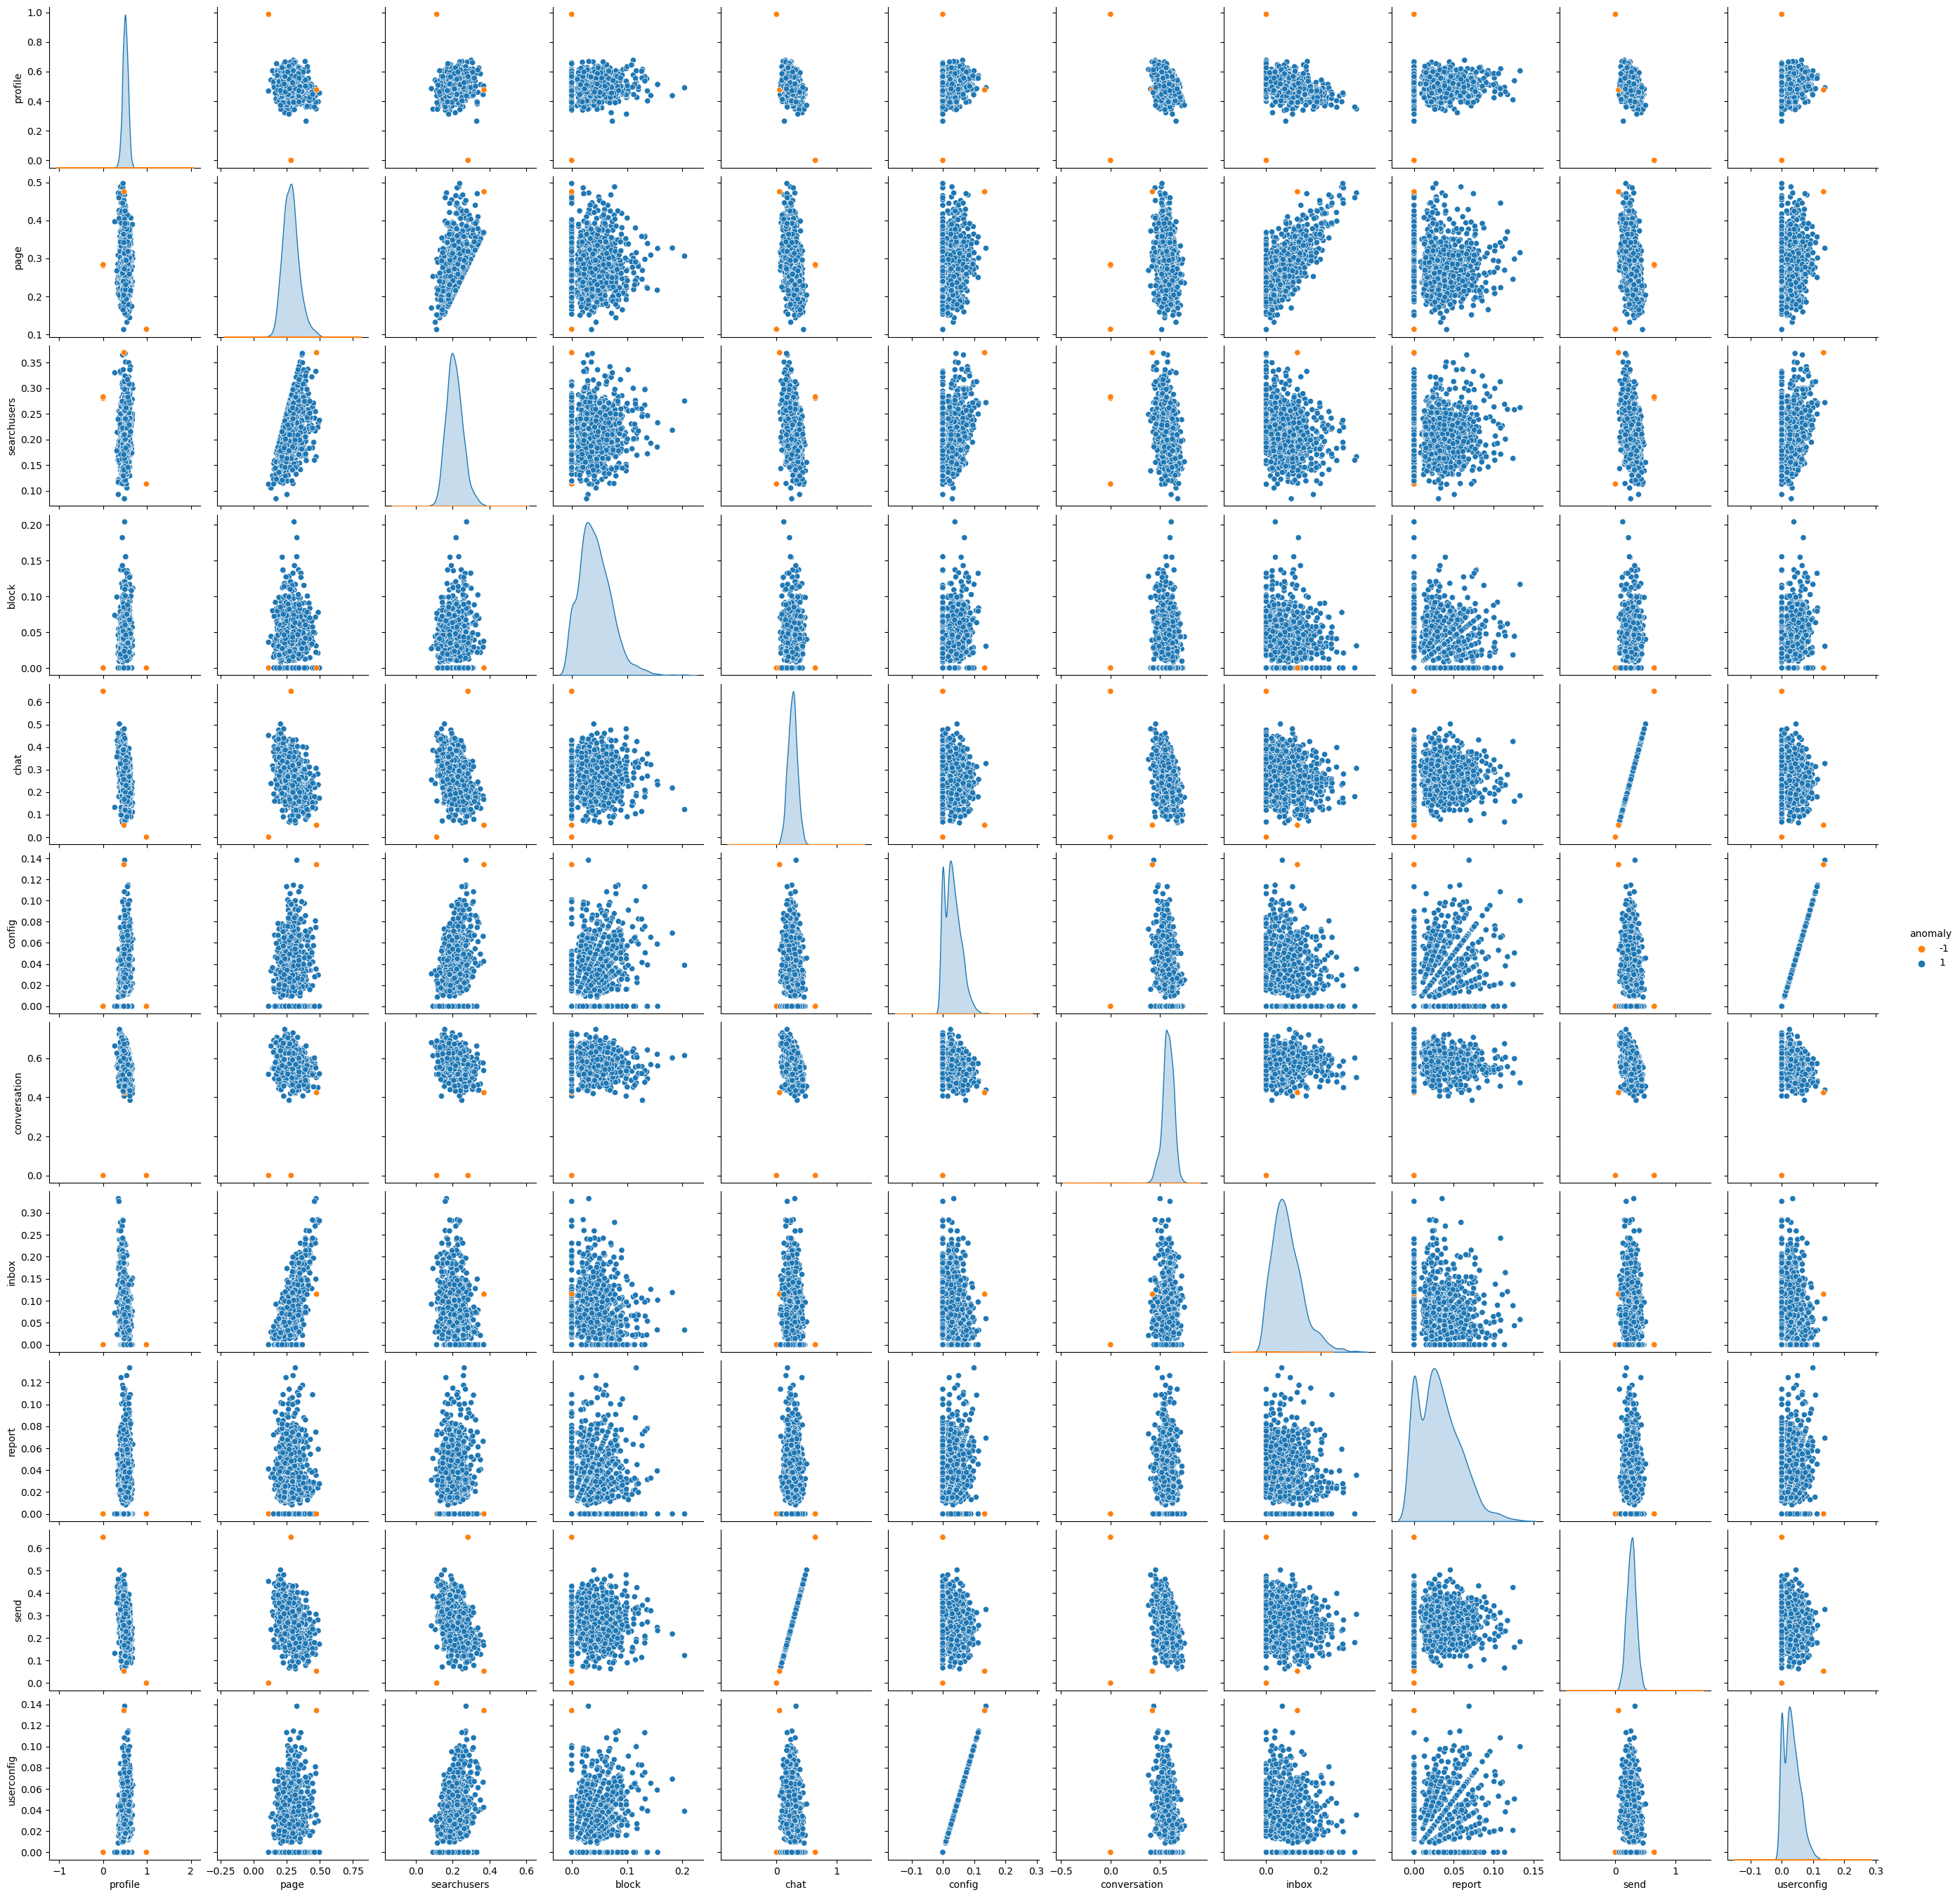

In [13]:
#Plots showcasing the outliers detected by isolation forest
palette = ['#ff7f0e', '#1f77b4']
sns.pairplot(df_tfidf_scores, vars=anomaly_inputs, hue='anomaly', palette=palette)


**Testing out TSNE**

In [14]:
#Visualizing data with t-SNE
embedded_data = TSNE(perplexity=50.0, n_iter=2000).fit_transform(np.asarray(vect_logs.todense()))
spammer1 = embedded_data[5]
spammer2 = embedded_data[6]
dataScraper = embedded_data[7]

c:\Users\rosin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\rosin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [15]:
plt.scatter(embedded_data[:,0], embedded_data[:,1])
plt.scatter(spammer1[0],spammer1[1], color='red')
plt.scatter(spammer2[0],spammer2[1], color='red')
plt.scatter(dataScraper[0],dataScraper[1], color='green')

**PCA: for dimension reduction**

In [16]:
X = np.asarray(vect_logs.todense())
pca = PCA()
pc = pca.fit_transform(X)
pc = pd.DataFrame(pc)
print(pc.shape)
pc

(1004, 15)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.014151,-0.056579,0.032928,-0.023269,0.055481,-0.034205,-0.040538,0.025775,-0.016518,0.009518,-1.280286e-16,-3.831713e-17,1.057929e-17,-2.338633e-18,-4.856402e-18
1,-0.004119,0.024946,-0.147911,-0.022661,0.028510,0.034089,-0.014530,0.004799,0.003663,-0.007788,-8.744214e-17,7.338508e-16,1.255754e-18,1.164123e-18,-1.868838e-18
2,-0.014892,-0.116458,-0.007735,0.021352,-0.046803,-0.034033,0.011968,0.011323,-0.003120,0.009117,-1.191586e-16,4.896034e-19,2.597761e-16,-8.735034e-18,5.820718e-19
3,0.053916,0.163665,-0.006286,0.058890,-0.023201,-0.003443,-0.069031,0.003830,0.044711,0.003305,-6.055011e-17,2.214700e-18,1.491026e-17,9.567101e-17,4.410390e-17
4,-0.117871,0.056486,-0.085556,-0.028776,0.044079,0.009919,-0.032389,0.033688,0.008695,0.033079,2.456695e-16,-6.957825e-18,1.102752e-18,4.682014e-18,-3.520608e-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,-0.003835,0.099379,0.097485,0.005731,-0.050682,0.024302,-0.019628,0.004157,-0.008210,-0.023072,-1.329339e-16,4.575345e-19,-3.629689e-18,-1.301168e-18,3.277074e-19
1000,0.065047,0.050680,-0.043768,0.016372,-0.001074,-0.001450,0.013162,0.007790,-0.017865,-0.020936,-1.153172e-16,-8.995457e-19,-4.964431e-20,1.634690e-19,-6.660678e-19
1001,-0.146306,-0.000804,-0.094498,-0.031923,-0.004844,0.033087,0.017118,-0.003498,0.002426,-0.018177,-9.874414e-17,1.573456e-18,4.964509e-19,1.209640e-18,-1.029603e-18
1002,-0.020214,-0.117290,-0.037662,0.069434,-0.017167,0.054558,0.004377,-0.023142,-0.014244,0.004660,-1.185357e-16,-5.354122e-19,-5.627769e-20,-2.431543e-18,2.037926e-18


In [17]:
print("Eigen values: ", list(np.round(pca.explained_variance_, decimals=5)))
print("PCA_variance_ratio: ", pca.explained_variance_ratio_)
print(pca.n_components)

Eigen values:  [0.01488, 0.00659, 0.0065, 0.0027, 0.00165, 0.00096, 0.00072, 0.00067, 0.00064, 0.00044, 0.0, 0.0, 0.0, 0.0, 0.0]
PCA_variance_ratio:  [4.16085399e-01 1.84349822e-01 1.81923581e-01 7.55255767e-02
 4.62256577e-02 2.67749579e-02 2.01896368e-02 1.87541698e-02
 1.79152153e-02 1.22559840e-02 3.65468573e-31 1.53534692e-32
 1.92533169e-33 4.23884406e-34 1.60565512e-34]
None


Following code just serves as a way to experiment using sequence of numbers. Could we use tfidf for vectorizing data?

In [18]:
#Function to create a sequence of numbers. Approx. 10% of the sequences will consist of duplicates of the same number
import random

def create_sequence(arr, randVal):
    if (randVal < 1):
        val = random.randint(1,9)
        for i in range (50):
            arr.append(val)
    else:    
        for i in range (0, 50):
            arr.append(random.randint(1,9))
    return arr    

In [19]:
#Function to give a sequence a score depending on number of consecutive duplicates
def sequence_evaluation(df):
    arr = []
    for i in range (0, df.shape[0]):
        data = df.iloc[i].to_list()
        score = 0
        lr = 0.1
        val = data[0]
        for j in range (1, len(data)):
            if (data[j] == val):
                score -= lr*data[j]
                if(lr < 1):
                    lr += 1.1*lr
            else:
                score += data[j]
                val = data[j]
        arr.append(score) 
    return arr     

In [20]:
#Function that calculates length of the longest subsequence of consecutive duplicates for each sequence
from itertools import groupby

def longestConsecutive(df):
    arr = []
    for i in range (0, df.shape[0]):
        longest_streak = len(max([list(group) for _, group in groupby(df.iloc[i].to_list())], key=len))
        arr.append(longest_streak)
    return arr

In [21]:
#Creation of the sequence data frame
sequence_matrix = []
for i in range (1000):
    randVal = random.randint(0,9)
    arr = []
    sequence_matrix.append(create_sequence(arr, randVal))

sequence_df = pd.DataFrame(sequence_matrix)

sequence_df['score'] = sequence_evaluation(sequence_df)
sequence_df['longestConsec'] = longestConsecutive(sequence_df.loc[:, sequence_df.columns != 'score'])
sequence_df

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,score,longestConsec
0,7,9,7,3,2,3,7,1,7,3,...,5,2,6,9,6,2,9,6,195.60408,3
1,5,6,4,4,1,6,4,7,1,6,...,2,5,9,2,3,8,9,2,231.92500,2
2,6,9,7,4,2,7,5,3,2,8,...,6,8,9,7,1,5,9,3,210.82483,2
3,3,5,8,1,6,4,9,5,1,1,...,5,1,8,6,4,6,9,2,194.92892,3
4,3,1,9,8,1,7,2,3,7,8,...,7,4,6,3,4,7,4,8,233.27500,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,5,7,3,8,9,7,2,3,4,4,...,5,8,5,6,7,3,6,1,186.75379,2
996,9,5,1,6,4,3,3,9,6,4,...,4,7,9,3,6,8,5,5,229.94850,2
997,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,-713.54840,50
998,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,-178.38710,50


In [22]:
#A yanky scatter plot....
plt.scatter(sequence_df['longestConsec'], sequence_df['score'])